In [1]:
import os
from torch.utils.data import DataLoader
from dataloader_e2e import create_dataset_12
import matplotlib.pyplot as plt
from PIL import ImageOps
import torchvision
import numpy as np
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import *

path = os.getcwd()
path = '/root/notebooks/sample/dataset/ECG100_224/'
train_dataloader,test_dataloader,label_lead=create_dataset_12(path,1,None)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)


/python/build/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classification lab : {'Lateral': 0, 'Posterior': 1, 'Anterior': 2, 'Inferior': 3, 'Normal': 4}
Number of datas 378
torch.Size([12, 378, 3, 112, 224])
378
378
cpu


In [2]:
class MeanLayer(nn.Module):
    def forward(self, x):
        return torch.mean(x, dim=0, keepdim=True)

In [3]:
# モデルクラス
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 畳み込み層や全結合層などを定義する
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.faltten = nn.Flatten()
        self.fc1 = nn.Linear(16,16)
        self.fc2 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = self.faltten(x)
        #x = x.view(-1, 16 * 56 * 112)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデルのインスタンスを作成
model = CNNModel().to(device)
print(model)

model = nn.Sequential(
    model,
    MeanLayer()
)

print(model)


CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (faltten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=5, bias=True)
)
Sequential(
  (0): CNNModel(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (gap): AdaptiveAvgPool2d(output_size=1)
    (faltten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_featu

In [4]:
## 診断 (事前学習なし)

# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=0.00001)
bestscore_dx = 1000.0
loss_list_dx,loss_list_test_dx = [], []
f1s_dx, f1s_test_dx = [],[]
acc_dx, acc_test_dx = [], []

num_epochs_dx = 20000

# モデル訓練　5クラス分類

for epoch in range(num_epochs_dx):
    model.train()
    running_loss_dx = 0.0
    preds_dx, label_dx = [], []
    running_loss_dx, running_loss_test_dx = 0.0, 0.0
    preds_test_dx,label_test_dx = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = model(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_dx.extend(pred.tolist())
        label_dx.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_dx += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = model(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_dx.extend(pred.tolist())
        label_test_dx.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_dx += loss.item()
    
    score_dx = running_loss_test_dx/len(test_dataloader)
    if score_dx < bestscore_dx:
        bestscore_dx = score_dx
        torch.save(model.state_dict(), '/root/notebooks/sample/models/bestmodel_dx_no_pretrain.pth')
        print('best score_dx!!')
    loss_list_dx.append(running_loss_dx/len(train_dataloader))
    loss_list_test_dx.append(running_loss_test_dx/len(test_dataloader))
    f1_dx = f1_score(preds_dx,label_dx,average='macro')
    f1_test_dx = f1_score(preds_test_dx,label_test_dx,average='macro')
    f1s_dx.append(f1_dx)
    f1s_test_dx.append(f1_test_dx)
    accuracy_dx = accuracy_score(preds_dx,label_dx)
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    acc_dx.append(accuracy_dx)
    acc_test_dx.append(accuracy_test_dx)

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs_dx}] Train-Loss: {running_loss_dx/len(train_dataloader)} Test-Loss: {running_loss_test_dx/len(train_dataloader)} Train-f1: {f1_dx} Test-f1: {f1_test_dx} Train-acc: {accuracy_dx} Test-acc: {accuracy_test_dx}")

best score_dx!!
Epoch [1/20000] Train-Loss: 1.7278143433715947 Test-Loss: 0.4339102976594917 Train-f1: 0.006514657980456026 Test-f1: 0.005194805194805195 Train-acc: 0.016556291390728478 Test-acc: 0.013157894736842105
best score_dx!!
Epoch [2/20000] Train-Loss: 1.7183745000214692 Test-Loss: 0.43141360911264753 Train-f1: 0.006514657980456026 Test-f1: 0.005194805194805195 Train-acc: 0.016556291390728478 Test-acc: 0.013157894736842105
best score_dx!!
Epoch [3/20000] Train-Loss: 1.7079326320585246 Test-Loss: 0.42862139749288647 Train-f1: 0.006514657980456026 Test-f1: 0.005194805194805195 Train-acc: 0.016556291390728478 Test-acc: 0.013157894736842105
best score_dx!!
Epoch [4/20000] Train-Loss: 1.6955336160588559 Test-Loss: 0.42524422020786345 Train-f1: 0.006514657980456026 Test-f1: 0.005194805194805195 Train-acc: 0.016556291390728478 Test-acc: 0.013157894736842105
best score_dx!!
Epoch [5/20000] Train-Loss: 1.6850118673469143 Test-Loss: 0.4232538364520874 Train-f1: 0.006514657980456026 Test-

KeyboardInterrupt: 

In [5]:
# モデル評価 ５クラス診断
pred_dx,label_dx = [],[]
model.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_dx_no_pretrain.pth'))
model.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_dx.extend(labels.tolist())
    outputs = model(image)  # モデルの出力を計算
    prob_dx, preds_dx=torch.max(outputs,1)
    pred_dx.extend(preds_dx.tolist())
    f1_test_dx = f1_score(preds_dx.tolist(),labels.tolist(),average='macro')
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_dx += loss.item()

print(f1_test_dx)
print(accuracy_test_dx)

/python/build/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/python/build/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/python/build/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/python/build/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/python/build/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/python/build/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/python/build/lib/python3.10/site-packages/numpy/lib

1.0
nan


/python/build/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/python/build/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/python/build/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/python/build/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/python/build/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/python/build/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/python/build/lib/python3.10/site-packages/numpy/lib

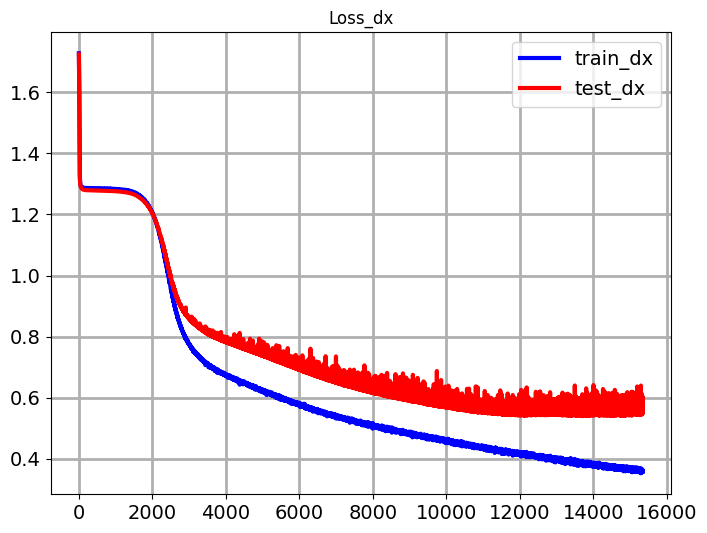

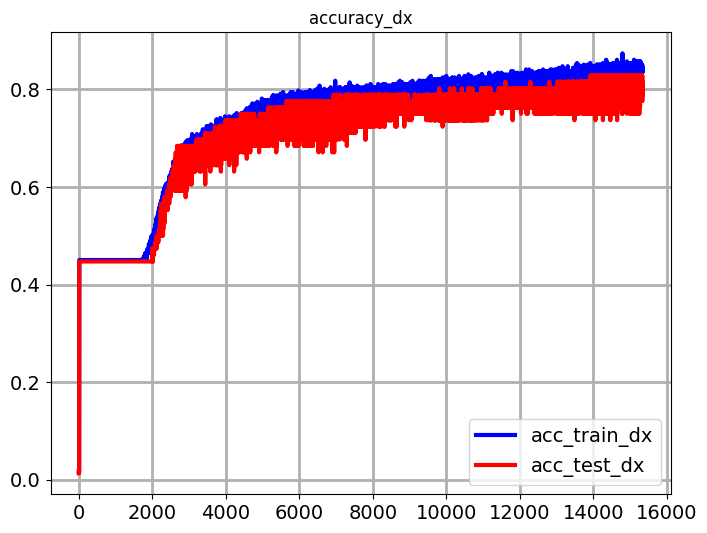

In [6]:
# 学習曲線 (損失関数) 事前学習
plt.figure(figsize=(8,6))
plt.plot(loss_list_dx,label='train_dx', lw=3, c='b')
plt.plot(loss_list_test_dx,label='test_dx', lw=3, c='r')
plt.title('Loss_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (精度)
plt.figure(figsize=(8,6))
plt.plot(acc_dx,label='acc_train_dx', lw=3, c='b')
plt.plot(acc_test_dx,label='acc_test_dx', lw=3, c='r')
plt.title('accuracy_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()